<a href="https://colab.research.google.com/github/asthajha0211/Telemarketing-Bank-Prospects/blob/main/Big_Data_J_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/banking-dataset-marketing-targets/train.csv
/kaggle/input/banking-dataset-marketing-targets/test.csv


# 0. Importing other necessary packages

In [ ]:
# Encoding
from sklearn import preprocessing

# Splitting and scaling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Balancing data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Pipelines
from imblearn.pipeline import Pipeline

# Stratified K-Fold
from sklearn.model_selection import StratifiedKFold

# Metrics and cross validation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

# I. DATA CLEANING

## Loading data

In [ ]:
df = pd.read_csv('../input/banking-dataset-marketing-targets/train.csv', sep = ';')

In [ ]:
# Checking if data was loaded properly
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [ ]:
df.tail(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [ ]:
# Checking the summary of our main dataset (train.csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
# Checking summary statistics for numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


**We can see here that the minimum value for `duration`, which talks about the duration of the last contact, is `0`. However, the minimum value for `campaign`, which is the number of contacts made during this campaign (including the last contact), is `1`. This might indicate that the telephone call was dropped after connecting if these were a small amount of datapoints.**

In [ ]:
# Further checking the number of datapoints that had 0 seconds for 'duration'
print("The number of clients that had a call duration of 0:", df[df['duration'] == 0].duration.count())

The number of clients that had a call duration of 0: 3


**This can indicate the possibility that the phone call was instantly dropped, which can happen.**

**Additionally, we verify the validity of the features `previous` and `pdays`. It should be noted that all clients with `pdays = -1` indicates that the client was not previously contacted, which implies that `previous = 0`.**

In [ ]:
# Verifying 'previous' and 'pdays'
df[df['pdays'] == -1].previous.sum()

0

**The `previous` and `pdays` features check out.**

In [ ]:
# Checking summary statistics for categorical features
df.describe(include = 'object').T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


## Checking missing values

In [ ]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

**There are no missing values**

## Checking for duplicates

In [ ]:
df.duplicated().value_counts()

False    45211
dtype: int64

**There are no duplicated data.**

## Checking misspelled columns / improving column names

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

**The column names are okay, but they can be improved for clarity. We can change them into the following:**

- `marital` > `marital_status`
- `education` > `educational_attainment`
- `default` > `credit_default`
- `balance` > `yearly_balance_ave`
- `housing` > `housing_loan`
- `loan` > `personal_loan`
- `contact` > `contact_type`
- `day` > `last_contact_day`
- `month` > `last_contact_month`
- `duration` > `last_contact_duration`
- `campaign` > `current_contact_count`
- `pdays` > `previous_idle_days`
- `previous` > `previous_contact_count`
- `poutcome` > `previous_outcome`
- `y` > `current_outcome`

In [ ]:
# Renaming columns
df.rename(columns = {'marital':'marital_status', 'education':'educational_attainment',
                     'default':'credit_default', 'balance':'yearly_balance_ave',
                     'housing':'housing_loan', 'loan':'personal_loan',
                     'contact':'contact_type', 'day':'last_contact_day',
                     'month':'last_contact_month', 'duration':'last_contact_duration',
                     'campaign':'current_contact_count', 'pdays':'previous_idle_days',
                     'previous':'previous_contact_count', 'poutcome':'previous_outcome',
                     'y':'current_outcome'}, inplace = True)

#df_test.rename(columns = {'marital':'marital_status', 'education':'educational_attainment',
#                          'default':'credit_default', 'balance':'yearly_balance_ave',
#                          'housing':'housing_loan', 'loan':'personal_loan',
#                          'contact':'contact_type', 'day':'last_contact_day',
#                          'month':'last_contact_month', 'duration':'last_contact_duration',
#                          'campaign':'current_contact_count', 'pdays':'previous_idle_days',
#                          'previous':'previous_contact_count', 'poutcome':'previous_outcome',
#                          'y':'current_outcome'}, inplace = True)

# Checking updated column names
df.columns

Index(['age', 'job', 'marital_status', 'educational_attainment',
       'credit_default', 'yearly_balance_ave', 'housing_loan', 'personal_loan',
       'contact_type', 'last_contact_day', 'last_contact_month',
       'last_contact_duration', 'current_contact_count', 'previous_idle_days',
       'previous_contact_count', 'previous_outcome', 'current_outcome'],
      dtype='object')

## Checking misspelled column values

In [ ]:
df_cat = df.select_dtypes('object').columns
for col in df_cat:
    print(df[col].value_counts())
    print('===============')

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital_status, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: educational_attainment, dtype: int64
no     44396
yes      815
Name: credit_default, dtype: int64
yes    25130
no     20081
Name: housing_loan, dtype: int64
no     37967
yes     7244
Name: personal_loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact_type, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: last_contact_month, dtype: int64
unknown    36959
failure     4901
other

**There are no misspelled values for our categorical features. However, there are `unknown` values for various features, but we'll consider them as is for this version of the dataset.**

## Checking column data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     45211 non-null  int64 
 1   job                     45211 non-null  object
 2   marital_status          45211 non-null  object
 3   educational_attainment  45211 non-null  object
 4   credit_default          45211 non-null  object
 5   yearly_balance_ave      45211 non-null  int64 
 6   housing_loan            45211 non-null  object
 7   personal_loan           45211 non-null  object
 8   contact_type            45211 non-null  object
 9   last_contact_day        45211 non-null  int64 
 10  last_contact_month      45211 non-null  object
 11  last_contact_duration   45211 non-null  int64 
 12  current_contact_count   45211 non-null  int64 
 13  previous_idle_days      45211 non-null  int64 
 14  previous_contact_count  45211 non-null  int64 
 15  pr

**All columns have proper data types.**

## Checking outliers

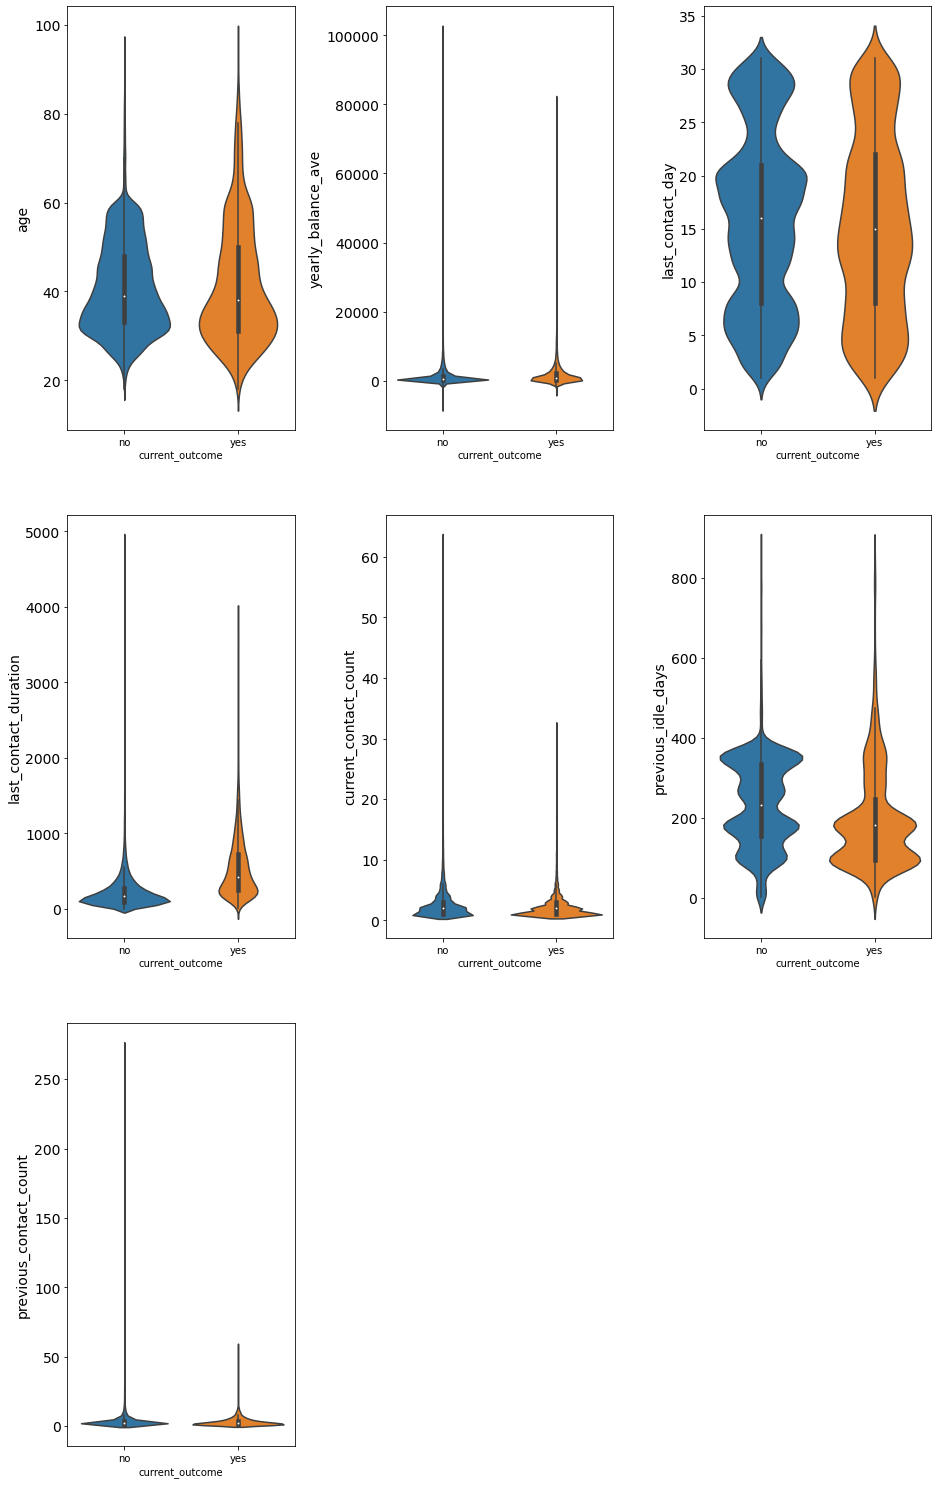

In [ ]:
df_num = df.select_dtypes('int').columns
plt.figure(figsize = (15, 25))
for idx, col in enumerate(df_num):
    plt.subplot(3, 3, idx + 1)
    if col == 'previous_idle_days':
        ax = sns.violinplot(data = df, y = df[df[col] > -1][col], x = df.current_outcome, inner = 'box')
    elif col == 'previous_contact_count':
        ax = sns.violinplot(data = df, y = df[df[col] > 0][col], x = df.current_outcome, inner = 'box')
    else:
        ax = sns.violinplot(data = df, y = df[col], x = df.current_outcome)
    #plt.axhline(df[col].mean(), color='red', linewidth=3)
    #plt.axhline(df[col].median(), color='green', linewidth=3)
    plt.ylabel(col, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)

**It can already be observed that clients that subscribed to a term deposit:**
- had `longer durations` for their `last contact` during the `current campaign`, and
- had `shorter number of days that passed` by after the client was `last contacted from a previous campaign`.

In [ ]:
#Can remove outliers using the IQR method where any value below Q1-1.5*IQR or above Q3+1.5*IQR is an Outlier

def outlier_density(df,col_name):
    #print("Orig DF Size:"+ str(df.shape))
    if col_name == 'previous_idle_days':
        Q1 = np.quantile(df[df[col_name] > -1][col_name],0.25)
        Q3 = np.quantile(df[df[col_name] > -1][col_name],0.75)
    elif col_name == 'previous_contact_count':
        Q1 = np.quantile(df[df[col_name] > 0][col_name],0.25)
        Q3 = np.quantile(df[df[col_name] > 0][col_name],0.75)
    else:
        Q1 = np.quantile(df[col_name],0.25)
        Q3 = np.quantile(df[col_name],0.75)

    IQR = Q3 - Q1

    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR)

    print("Lower Limit: %.2f" % lower_limit)
    print("Upper Limit: %.2f" % upper_limit)

    df_new = df[(df[col_name] > lower_limit) & (df[col_name] < upper_limit)]
    #print("New DF Size:"+ str(df_new.shape))
    print('Outlier count for ' + col_name + ': ' + str(df.shape[0] - df_new.shape[0]))
    print('Outlier density for ' + col_name + ': ' + str(round((1 - df_new.shape[0] / df.shape[0]) * 100, 4)) + '%')
    print('========')

In [ ]:
for col in df_num:
    outlier_density(df, col)

Lower Limit: 10.50
Upper Limit: 70.50
Outlier count for age: 487
Outlier density for age: 1.0772%
Lower Limit: -1962.00
Upper Limit: 3462.00
Outlier count for yearly_balance_ave: 4731
Outlier density for yearly_balance_ave: 10.4643%
Lower Limit: -11.50
Upper Limit: 40.50
Outlier count for last_contact_day: 0
Outlier density for last_contact_day: 0.0%
Lower Limit: -221.00
Upper Limit: 643.00
Outlier count for last_contact_duration: 3247
Outlier density for last_contact_duration: 7.1819%
Lower Limit: -2.00
Upper Limit: 6.00
Outlier count for current_contact_count: 4355
Outlier density for current_contact_count: 9.6326%
Lower Limit: -158.00
Upper Limit: 618.00
Outlier count for previous_idle_days: 49
Outlier density for previous_idle_days: 0.1084%
Lower Limit: -3.50
Upper Limit: 8.50
Outlier count for previous_contact_count: 453
Outlier density for previous_contact_count: 1.002%


**The `yearly_balance_ave`, `last_contact_duration`, and `current_contact_count` have a good amount of outliers. These outliers will not be removed for this version of the dataset, but further analysis will be done to see if these outliers can be removed in succeeding versions.**

**Exploration of these outliers will be done in the next Section II.**

# II. EXPLORATORY DATA ANALYSIS

## Balance of target `y`

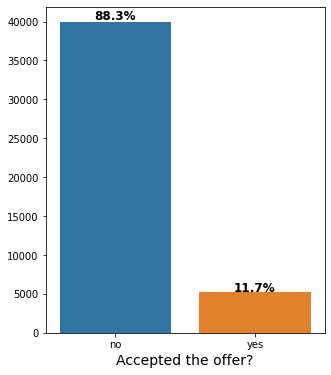

In [ ]:
plt.figure(figsize=(5,6))
ax = sns.countplot(data = df, x = df.current_outcome)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{round(height * 100 / df.shape[0], 2)}%', (x + width/2, y + height * 1.01), ha='center', weight = 'bold', fontsize = 12)
plt.xlabel(r'Accepted the offer?', fontsize = 14)
plt.ylabel(r'')
plt.show()

**We can see the we have a high imbalance in our classes. Techniques such as undersampling of the dominant class or SMOTE to increase the datapoints of the minority class can be done to improve on the balance of our target classes.**

**For now, we'll first stick to this balance in this version of the dataset. After finding the metrics of the imbalanced dataset, we will try to check the performance of the same calssification models can be improved by balancing data.**

## Feature engineering

**We can include a `quarter` feature as an additional column to describe the date to when calls where made based on `last_contact_month`.**

In [ ]:
# Creating a last_contact_quarter feature based on the last_contact_month feature
df['last_contact_quarter'] = np.where((df['last_contact_month'] == 'jan') | (df['last_contact_month'] == 'feb') | (df['last_contact_month'] == 'mar') , '1',
                             np.where((df['last_contact_month'] == 'apr') | (df['last_contact_month'] == 'may') | (df['last_contact_month'] == 'jun') , '2',
                             np.where((df['last_contact_month'] == 'jul') | (df['last_contact_month'] == 'aug') | (df['last_contact_month'] == 'sep') , '3',
                                    '4')))

**We can also include a `was_contacted_previously` feature to show whether a client was contacted during the previous campaign based on the `previous_idle_days` feature.**

**But before we engineer this new feature, let's check the `previous_outcome` for the clients that weren't contacted during the previous campaign.**

In [ ]:
df[df['previous_idle_days'] == -1]['previous_outcome'].value_counts()

unknown    36954
Name: previous_outcome, dtype: int64

**It can be seen that we have almost all (99.99% or 36954/36959) of clients that were not called during the previous campaign had an `unknown` status for the `previous_outcome`, which checks out.**

**We now create the `was_contacted_previously` feature:**

In [ ]:
# Creating a was_contacted_previously feature based on the previous_idle_days feature
df['was_contacted_previously'] = np.where(df['previous_idle_days'] > -1 , '1', '0')

## Numerical feature analysis

**We create a pairplot for all the numerical features to quickly see any relationships / correlations that exist.**

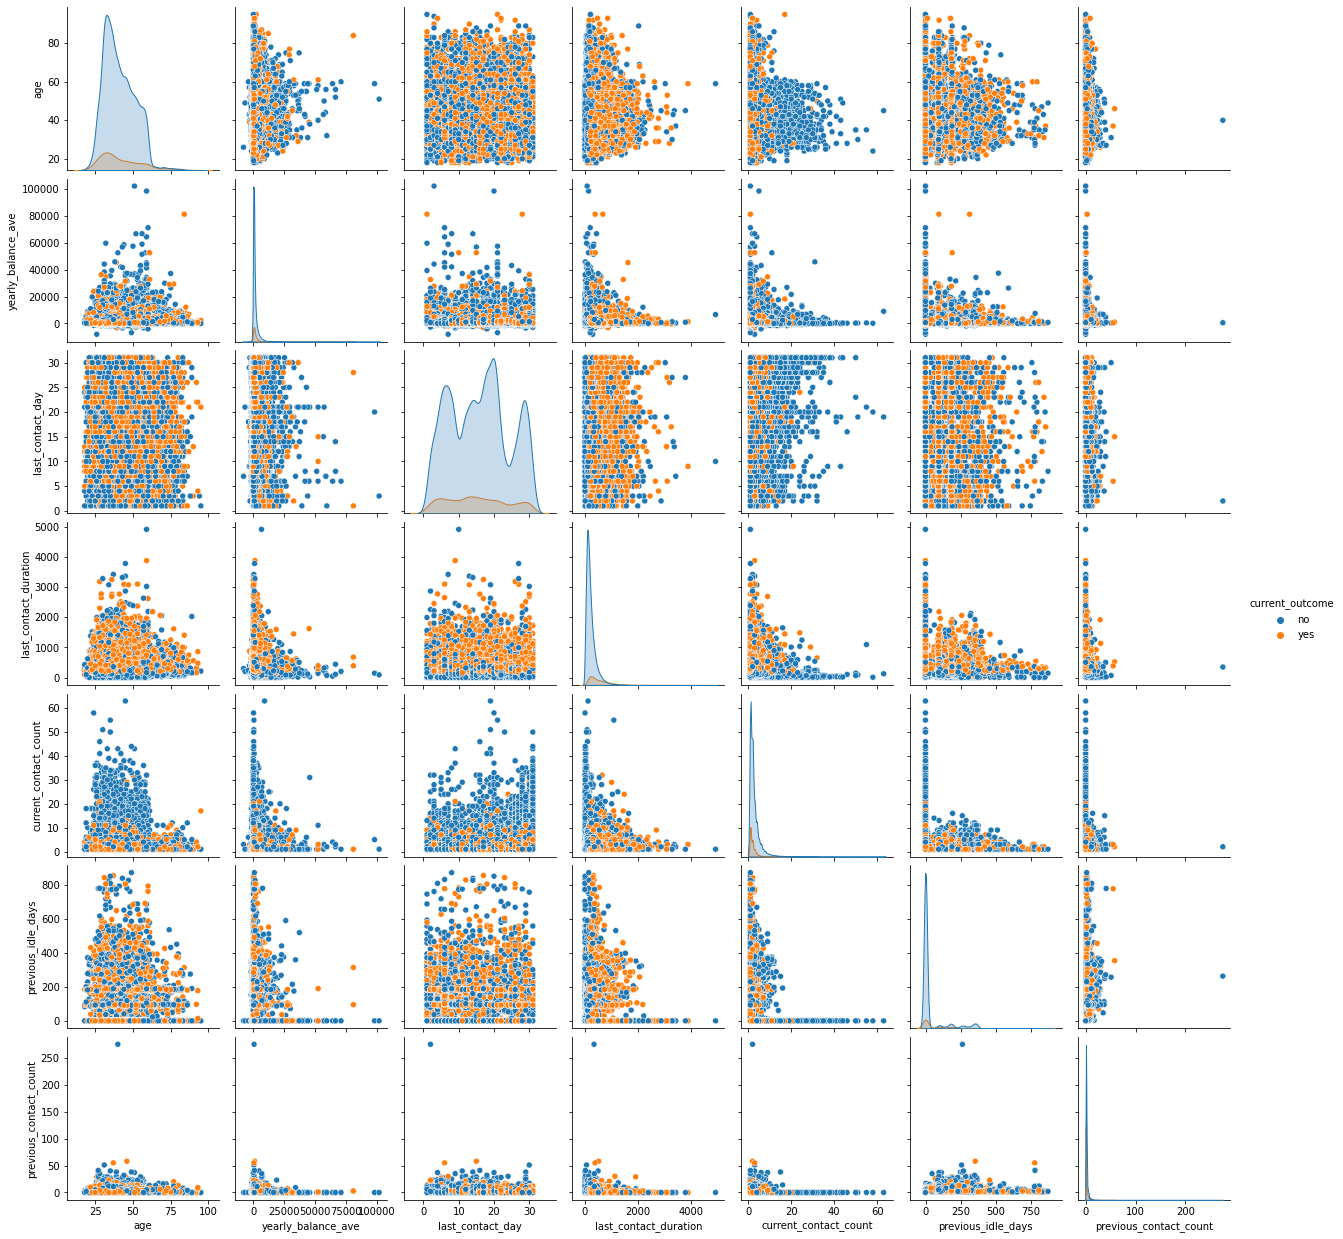

In [ ]:
col = ['age', 'yearly_balance_ave', 'last_contact_day', 'last_contact_duration',
       'current_contact_count', 'previous_idle_days', 'previous_contact_count', 'current_outcome']
sns.pairplot(data = df[col], hue = 'current_outcome')

**Some observations:**
- `Clients` the have ages `around 60 and above` have `lesser contact counts` during the `current campaign`.
- `Generally in all ages`, `clients` that `accepted to pay a term deposit` tend to have `lower current campaign contacts`.
- `Clients` of `lower yearly average balance` got `contacted more`.

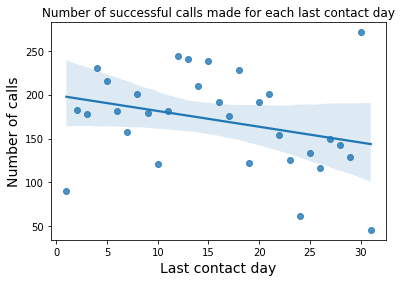

In [ ]:
contact_day_sum = df.groupby(['last_contact_day', 'current_outcome'], as_index = False)['age'].count()
contact_day_sum.rename(columns = {'age':'count'}, inplace = True)
contact_day_sum

sns.regplot(data = contact_day_sum[contact_day_sum['current_outcome'] == 'yes'],
             x = 'last_contact_day', y = 'count')
plt.xlabel(r'Last contact day', fontsize = 14)
plt.ylabel(r'Number of calls', fontsize = 14)
plt.title(r'Number of successful calls made for each last contact day')
plt.show()

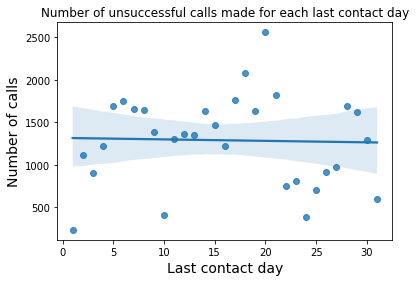

In [ ]:
sns.regplot(data = contact_day_sum[contact_day_sum['current_outcome'] == 'no'],
             x = 'last_contact_day', y = 'count')
plt.xlabel('Last contact day', fontsize = 14)
plt.ylabel('Number of calls', fontsize = 14)
plt.title(r'Number of unsuccessful calls made for each last contact day')
plt.show()

## Categorical feature analysis

In [ ]:
df_cat = df.select_dtypes('object')
df_cat.drop('current_outcome', axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


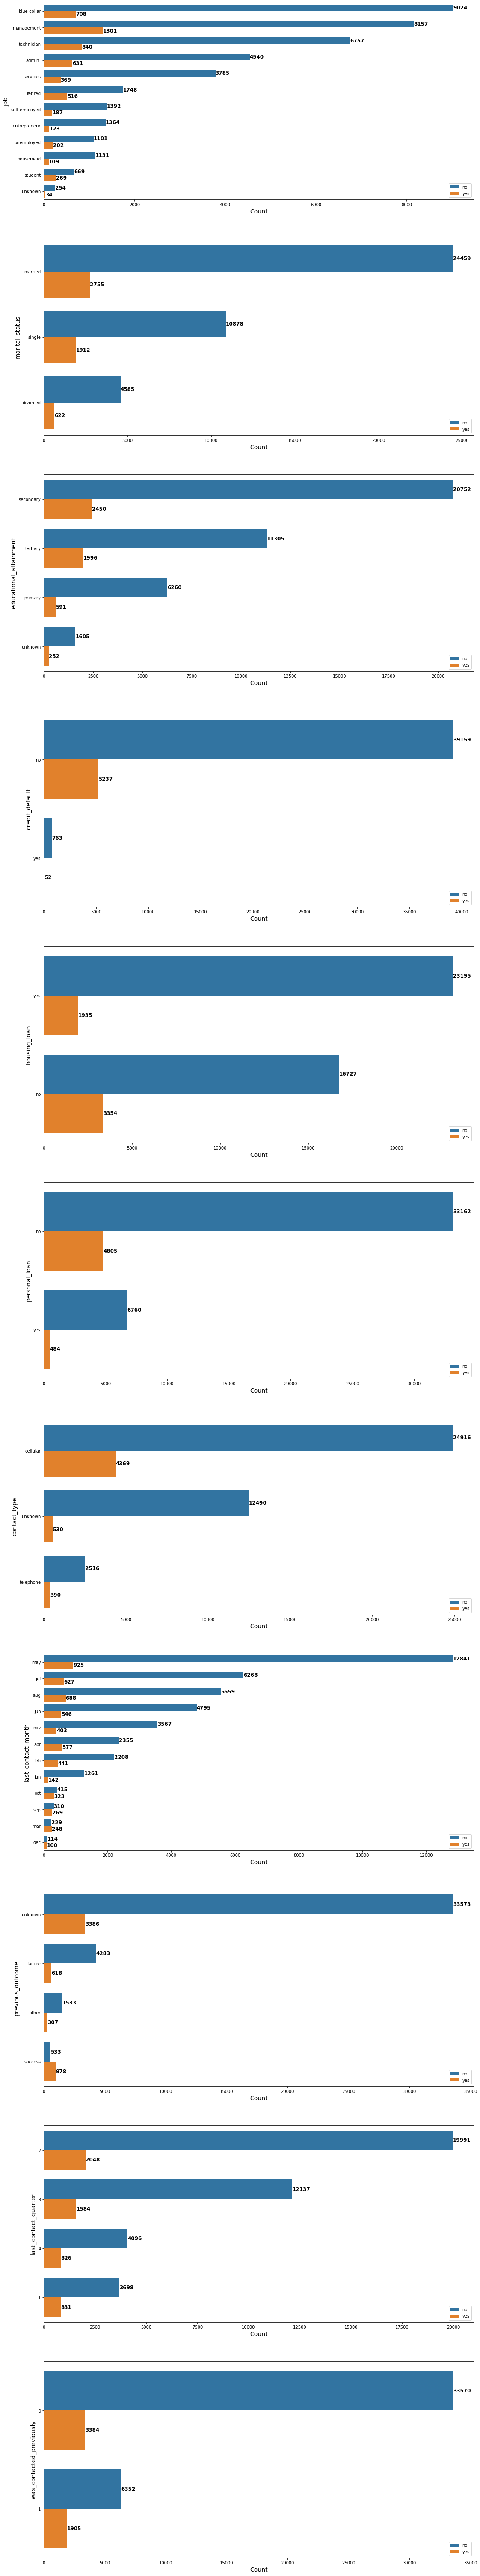

In [ ]:
plt.figure(figsize=(18,120))
for idx, col in enumerate(df_cat.columns):
    plt.subplot(12,1,idx + 1)
    ax = sns.countplot(data = df, y = df[col], hue = df['current_outcome'],
                       order = df[col].value_counts().index);
    plt.ylabel(col, fontsize = 14)
    plt.xlabel('Count', fontsize = 14)
    for col in ax.containers:     #to set a label on top of the bars.
        ax.bar_label(col, weight = 'bold', fontsize = 12)
    plt.legend(loc = 'lower right')

**Some observations:**
- `Most calls` attend to clients with `blue-collar jobs`, but with `most successes` being in clients with `managerial roles`.
- `Most calls` attend to `married` clients, with the `most number of successes as well`. However, the `best ratio of successes` relative to the total number of client belongs to `single` clients.
- `Most calls` attend to clients that finished `secondary education`, with the `most number of successes as well`. However, the `best ratio of successes` relative to the total number of client belongs to `clients that finished college`.
- `Most clients` have `default credit`.
- `More calls` attend to clients `with housing loans`, however `more successes` in terms of number and ratio relative to the total number of clients come from `clients without housing loans`.
- `More calls` attend to clients `without personal loans`, however `more successes` in terms of number and ratio relative to the total number of clients come from `clients with personal loans`.
- `Most calls` are through `cellular contact type`. There are also a `lot of calls` made from `unknown` contact types.
- `Most calls` were made `during summer to fall` (May to August). However, the `best ratio` of successful term deposits in terms of the number of clients within a particular month belong to `October, September, December, and March`. `Maybe` these dates correspond to certain times where `clients are more accessible` / there are `certain situations` where these dates let `clients accept to pay term deposits more`.
- `Most clients` were not previously contacted, but `more clients` that `paid` a term deposit during the `previous` campaign `also paid` for a term deposit `during the current campaign`.
- `A lot more clients` were `not contacted previously`, and these clients `tend to reject the current campaign` as well. However, a `better ratio` of successful term deposits came from `clients who were contacted previously`.

**Just a better representation of the `last_contact_month` feature:**

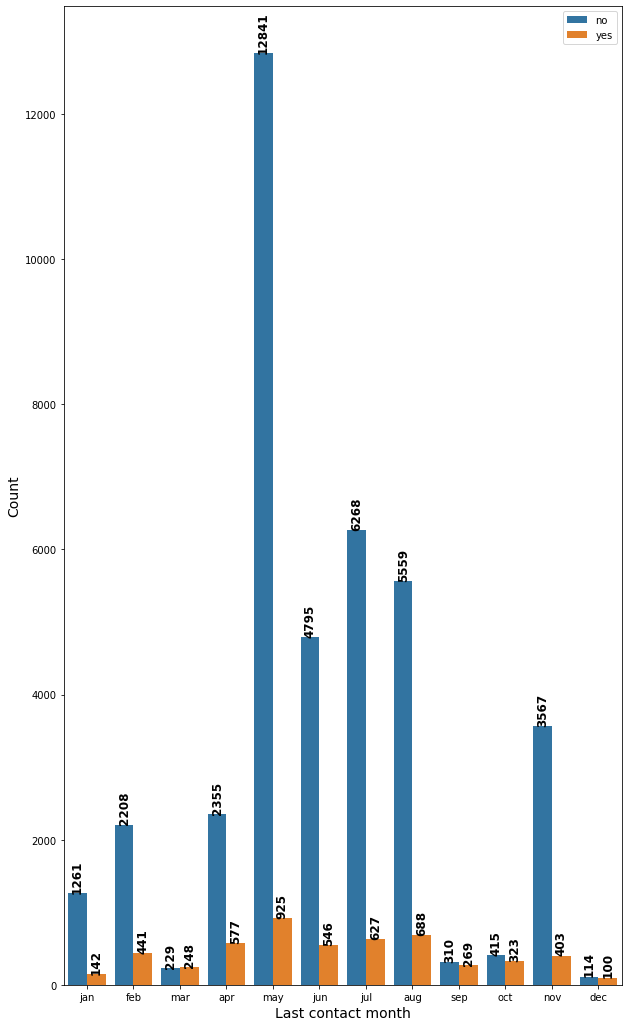

In [ ]:
plt.figure(figsize=(10,18))
ax = sns.countplot(data = df, x = df['last_contact_month'], hue = df['current_outcome'],
                   order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
                            'oct', 'nov', 'dec'])
plt.xlabel('Last contact month', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
for col in ax.containers:     #to set a label on top of the bars.
    ax.bar_label(col, weight = 'bold', fontsize = 12, rotation = 90)
plt.legend(loc = 'upper right')
plt.show()

# III. DATA PREMODELING

**We undergo additional feature engineering steps:**
- Vectorization
- Checking (and possibly removing) highly-correlated features

## Vectorization

In [ ]:
# Obtaining all the categorical features
df_cat = df.select_dtypes('object')
df_cat.columns

Index(['job', 'marital_status', 'educational_attainment', 'credit_default',
       'housing_loan', 'personal_loan', 'contact_type', 'last_contact_month',
       'previous_outcome', 'current_outcome', 'last_contact_quarter',
       'was_contacted_previously'],
      dtype='object')

**The following features will undergo labeled encoding: `job`, `educational_attainment`, `last_contact_month`, `last_contact_quarter`, and `current_outcome` before we undergo OHE.**

In [ ]:
# Encoding our target: Attrition_Flag
le = preprocessing.LabelEncoder()
df['job'] = le.fit_transform(df['job'])
df['educational_attainment'] = le.fit_transform(df['educational_attainment'])
df['last_contact_month'] = le.fit_transform(df['last_contact_month'])
df['last_contact_quarter'] = le.fit_transform(df['last_contact_quarter'])
df['current_outcome'] = le.fit_transform(df['current_outcome'])

In [ ]:
# Selecting all the remaining categorical features to one hot encode
df_cat = df.select_dtypes('object')

# One hot encoding
df = pd.get_dummies(df, df_cat.columns, drop_first = True)
df.head()

,age,job,educational_attainment,yearly_balance_ave,last_contact_day,last_contact_month,last_contact_duration,current_contact_count,previous_idle_days,previous_contact_count,...,marital_status_single,credit_default_yes,housing_loan_yes,personal_loan_yes,contact_type_telephone,contact_type_unknown,previous_outcome_other,previous_outcome_success,previous_outcome_unknown,was_contacted_previously_1
0,58,4,2,2143,5,8,261,1,-1,0,...,0,0,1,0,0,1,0,0,1,0
1,44,9,1,29,5,8,151,1,-1,0,...,1,0,1,0,0,1,0,0,1,0
2,33,2,1,2,5,8,76,1,-1,0,...,0,0,1,1,0,1,0,0,1,0
3,47,1,3,1506,5,8,92,1,-1,0,...,0,0,1,0,0,1,0,0,1,0
4,33,11,3,1,5,8,198,1,-1,0,...,1,0,0,0,0,1,0,0,1,0


## Correlations

<AxesSubplot:>

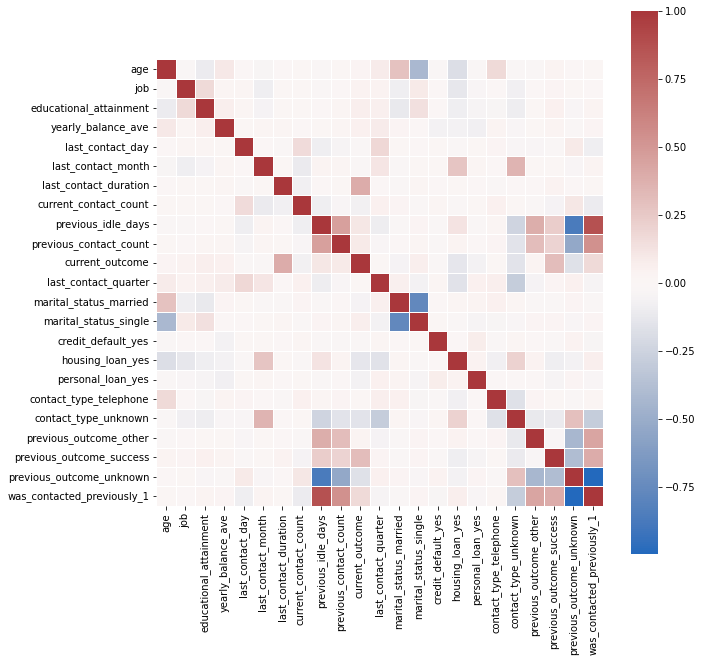

In [ ]:
# Obtaining correlations
corrmat = df.corr()

#Plotting the correlations
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, cmap="vlag", center = 0,  vmax=1, square=True, linewidths=.5)

In [ ]:
# We can also check for the correlations of feature pairs using the function below
def correlated_pairs(df, threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Reshape the Matrix
    correlated = corr_matrix.unstack()

    # Reset index from multi-index to single index
    correlated = correlated.reset_index(level = 0).reset_index()

    # Rename Columns
    correlated.columns = ["Feature1", "Feature2", "Correlation"]

    # sort by correlation value
    corr_sorted = correlated.sort_values("Correlation", ascending = False)

    # remove self-correlated rows
    corr_sorted_pairs = corr_sorted[corr_sorted['Feature1'].values != corr_sorted['Feature2'].values]

    # reset index to easily filter out duplicate rows
    corr_sorted_pairs.reset_index(drop = True, inplace = True)

    # skip odd rows to remove redundant pairs
    corr_sorted_final = corr_sorted_pairs.iloc[::2]

    # select rows based on threshold
    corr_sorted_final_ver = corr_sorted_final[corr_sorted_final.Correlation > threshold]

    return corr_sorted_final_ver

In [ ]:
# Obtaining highest correlated pairs
corr_sorted_final_ver = correlated_pairs(df, 0)
corr_sorted_final_ver.head()

,Feature1,Feature2,Correlation
0,previous_outcome_unknown,was_contacted_previously_1,0.999630
2,was_contacted_previously_1,previous_idle_days,0.870442
4,previous_idle_days,previous_outcome_unknown,0.869962
6,marital_status_married,marital_status_single,0.772357
8,previous_contact_count,was_contacted_previously_1,0.532988


## Handling highly-correlated features

**We can opt to remove highly correlated features using the function below:**

In [ ]:
# Function that identifies all the features that have correlation values that meet or surpass the
# given threshold
def correlation_filter(df, threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than threshold
    correl = [column for column in upper.columns if any(upper[column] >= threshold)]

    return correl

In [ ]:
to_drop = correlation_filter(df, 0.99)
to_drop

['was_contacted_previously_1']

**Since we have a clost-to-perfect correlation between two features: `previous_outcome_unknown` and `was_contacted_previously_1`, one feature will be removed. The rest of the features will be kept for this version of the dataset.**

In [ ]:
df.drop(to_drop, axis = 1, inplace = True)

# IV. DATA MODELING

**For the data modelling part, instead of just focusing on testing one subset of data from the training dataset, cross validation will be done.**

**After splitting the data, we will create various machine learning classifiers and identify the best model out of the bunch using the original imbalanced data. We will also run the same models under balanced data through oversampling by SMOTE and compare the results if there's an improvement in performance.**

## Data splitting

In [ ]:
# Separating our features and target
features = df.drop('current_outcome', axis = 1)
target = df['current_outcome']

## Instantiating the pipelines along with the components

In [ ]:
scaler = StandardScaler() # Scaler

logreg = LogisticRegression(random_state = 0) # Logistic Regression
rf = RandomForestClassifier(random_state = 0) # Random Forest Classifier
gbm = GradientBoostingClassifier(random_state = 0) # Gradient Boosting Model
xgbm = xgb.XGBClassifier() # Extreme Gradient Boosting Model

# Pipelines
logreg_pipe = Pipeline([('scaler',scaler), ('logreg', logreg)])
rf_pipe = Pipeline([('scaler',scaler), ('rf', rf)])
gbm_pipe = Pipeline([('scaler',scaler) , ('gbm', gbm)])
xgbm_pipe = Pipeline([('scaler',scaler) , ('xgbm', xgbm)])

## Training, testing, and comparison of performance metrics across the different models

**We note that one of the important metrics that we have to consider here is precision, since we want to reduce the number of clients that will be predicted as people who will pay term deposits but will actually not. This, in turn, will reduce costs for telephonic companies since they can now focus on clients that will actually pay term deposits.**

**First, we check on the performance metrics for our model in predicting each class using `train_test_split`**

In [ ]:
# Splitting the data (w/ shuffling and using stratification)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20,
                                                    shuffle = True, stratify = target)

In [ ]:
classifiers = [logreg_pipe, rf_pipe, gbm_pipe, xgbm_pipe]
classifier_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Extreme Gradient Boosting']

for clf, label in zip(classifiers, classifier_names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("For the", label, "model:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC score: " + "{0:.2%}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
    print("==========")

For the Logistic Regression model:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.66      0.32      0.43      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.65      0.69      9043
weighted avg       0.89      0.90      0.89      9043

ROC-AUC score: 89.74%
For the Random Forest model:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.67      0.41      0.51      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.69      0.73      9043
weighted avg       0.90      0.91      0.90      9043

ROC-AUC score: 93.13%
For the Gradient Boosting model:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.41      0.51      1058

    accuracy                           0.

**Our model performances are good in terms of accuracy and ROC-AUC score, but really low in the other performance metrics, specifically on the metrics for predicting our minority class (people who will invest term deposits when called by telephone marketing campaigners).**

**Confirming it through cross-validation:**

In [ ]:
# Additional parameter for cross validation
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [ ]:
# Creating a function that does our cross validation
def cross_validation(classifiers, classifier_names, cv):

    # Arrays to store various metrics
    accs = [] # accuracy
    accstd = [] # accuracy std
    precs = [] # precision
    precstd = [] # precision std
    recs = [] # recall
    recstd = [] # recall std
    f1s = [] # f1-score
    f1std = [] # f1-score std
    rocs = [] # roc_auc
    rocstd = [] # roc_auc std

    # Zip iterates through both lists simultaneously
    for clf, label in zip(classifiers, classifier_names):

        # Get the cross validated accuracy
        acc = cross_val_score(clf, features, target, cv = cv, scoring='accuracy', n_jobs= -1)
        avg_acc = acc.mean() * 100
        std_acc = acc.std() * 100

        # Get the cross validated precision
        prec = cross_val_score(clf, features, target, cv = cv, scoring='precision', n_jobs= -1)
        avg_prec = prec.mean() * 100
        std_prec = prec.std() * 100

        # Get the cross validated recall
        rec = cross_val_score(clf, features, target, cv = cv, scoring='recall', n_jobs= -1)
        avg_rec = rec.mean() * 100
        std_rec = rec.std() * 100

        # Get the cross validated f1_score
        f1 = cross_val_score(clf, features, target, cv = cv, scoring='f1', n_jobs= -1)
        avg_f1 = f1.mean() * 100
        std_f1 = f1.std() * 100

        # Get the cross validated roc_auc
        roc = cross_val_score(clf, features, target, cv = cv, scoring='roc_auc', n_jobs= -1)
        avg_roc = roc.mean() * 100
        std_roc = roc.std() * 100

        # Store scores in an array
        accs.append(float("{:.2f}".format(avg_acc)))
        accstd.append(float("{:.2f}".format(std_acc)))
        precs.append(float("{:.2f}".format(avg_prec)))
        precstd.append(float("{:.2f}".format(std_prec)))
        recs.append(float("{:.2f}".format(avg_rec)))
        recstd.append(float("{:.2f}".format(std_rec)))
        f1s.append(float("{:.2f}".format(avg_f1)))
        f1std.append(float("{:.2f}".format(std_f1)))
        rocs.append(float("{:.2f}".format(avg_roc)))
        rocstd.append(float("{:.2f}".format(std_roc)))
        print(clf)

    # Creating DataFrame to summarize
    data = {'Accuracy': accs,
            'Accuracy_std': accstd,
            'Precision': precs,
            'Precision_std': precstd,
            'Recall': recs,
            'Recall_std': recstd,
            'F1 Score': f1s,
            'F1 Score_std': f1std,
            'ROC-AUC': rocs,
            'ROC-AUC_std': rocstd}
    df_metrics = pd.DataFrame(data, index = classifier_names)

    return df_metrics

In [ ]:
# Performing cross-validation
classifiers = [logreg_pipe, rf_pipe, gbm_pipe, xgbm_pipe]
classifier_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Extreme Gradient Boosting']

display(cross_validation(classifiers, classifier_names, cv))

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(random_state=0))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=0))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('gbm', GradientBoostingClassifier(random_state=0))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_

,Accuracy,Accuracy_std,Precision,Precision_std,Recall,Recall_std,F1 Score,F1 Score_std,ROC-AUC,ROC-AUC_std
Logistic Regression,89.97,0.17,64.32,1.49,31.99,0.71,42.73,0.93,88.99,0.41
Random Forest,90.65,0.29,65.83,2.22,41.88,0.66,51.19,1.16,93.00,0.18
Gradient Boosting,90.59,0.22,65.70,1.72,40.93,1.15,50.43,1.11,92.47,0.32
Extreme Gradient Boosting,90.60,0.17,62.82,0.88,48.23,1.46,54.56,1.11,93.17,0.21


**One possible reason for this very poor performance metrics is from our imbalanced dataset.**

**One way to improve on our performance metrics as well is to balance out our dataset.**

**With all these observations, the `Random Forest Classifier for the non-balanced dataset (65.83% Precision and 41.88% Recall) produced the highest precision`. However, the `Extreme Gradient Boosting Classifier for the balanced dataset through SMOTE (60.66% Precision and 55.06% Recall) was considered` for further analysis since it also has `one of the best precision scores with a relatively good improvement on its recall`.**

**To further showcase the performance of our best model, below are some additional metrics. Note that these metrics were also done with cross-validation.**

### Confusion matrix

[Text(0, 0.5, 'Unsuccessful'), Text(0, 1.5, 'Successful')]

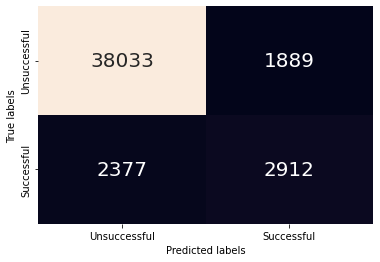

In [ ]:
# Pipeline
xgbm_pipe_sm = Pipeline([('scaler',scaler), ('xgbm', xgbm)])

y_pred = cross_val_predict(xgbm_pipe_sm, features, target, cv=cv)
conf_mat = confusion_matrix(target, y_pred)

ax = sns.heatmap(conf_mat, cbar = False, fmt = 'g', annot = True, annot_kws={"size":20})

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Unsuccessful', 'Successful'])
ax.yaxis.set_ticklabels(['Unsuccessful', 'Successful'])

### ROC-AUC

**Another way of visualizing the performance of our model is through the use of ROC-AUCs. Referencing the [code done by DATAI](https://www.kaggle.com/code/kanncaa1/roc-curve-with-k-fold-cv/notebook):**

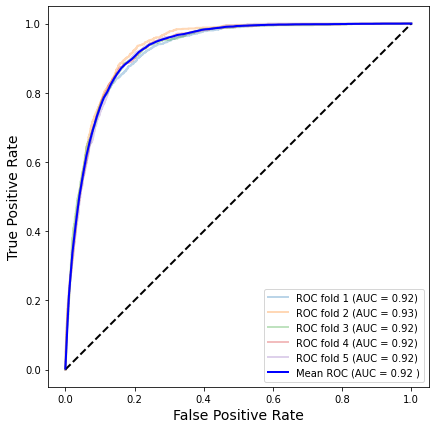

In [ ]:
m# plot arrows
fig1 = plt.figure(figsize=[7,7])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(features, target):
    prediction = gbm_pipe.fit(features.iloc[train], target.iloc[train]).predict_proba(features.iloc[test])
    fpr, tpr, t = roc_curve(target.iloc[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.legend(loc="lower right")
plt.savefig('ROC.jpg', bbox_inches='tight')
plt.show()

### Feature importances

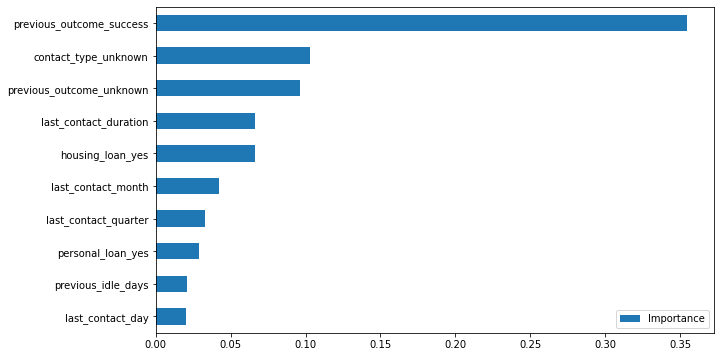

In [ ]:
# Extracting the feature importance
f_importance = xgbm_pipe_sm.steps[2][1].feature_importances_

# Putting into a DataFrame along with corresponding features.
f_list = features.columns
df_feature_importance = pd.DataFrame(f_importance, index=f_list, columns=["Importance"])

# Showing the 10 most important features
df_feature_importance_asc = df_feature_importance.sort_values(["Importance"],ascending=True)[-10:]

#Visualize importance using a plot, values should be ascending for plotting purposes
df_feature_importance_asc.plot(kind='barh', figsize=(10,6))
plt.show()

**It can be seen that the `main factor` in predicing whether a client will invest a term deposit when called in the current campaign is the `outcome of the previous telemarketing campaign` for those clients.**

**`Other important factors` revolve mostly on the `contact type`, the `previous outcome`, the `information regarding the last contact`, and information on whether the clients have `housing/personal loans`.**

# Conclusions

**We explored a dataset involving information regarding telephone marketing campaigns over clients with indication of whether or not they were contacted in the previous campaign, and whether or not the previous and current campaigns were successful. Different models were created over different versions of the dataset, since the dataset also underwent multiple balancing techniques. It was found that models under the non-balanced data set produced a decent value for precision but poor values for recall, and applying different balancing techniques produced models with improved recall for the price of precision.**

**Metrics can possible be further improved through using different models or doing hyperparameter optimization.**